In [63]:
!ls

Derek's datacleaning and visualization.ipynb
Directors Pie chart.png
Directors_Pie_chart.png
MovieProject-paul
Movie_Project_Draft.ipynb
README.md
bom.movie_gross.csv
name.basics.csv
rt.movie_info.tsv
rt.reviews.tsv
title.akas.csv
title.basics.csv
title.crew.csv
title.principals.csv
title.ratings.csv
tmdb.movies.csv
tn.movie_budgets.csv


In [64]:
!ls -a zippedData

ls: cannot access 'zippedData': No such file or directory


# Data Merge & Cleaning

## Import CSV Files

In [65]:
import pandas as pd

In [66]:
# Create Dataframes
n_b = pd.read_csv('name.basics.csv')

In [67]:
t_a = pd.read_csv('title.akas.csv')

In [68]:
t_b = pd.read_csv('title.basics.csv')

In [69]:
t_p = pd.read_csv('title.principals.csv')

In [70]:
m_b = pd.read_csv('tn.movie_budgets.csv')

In [71]:
# Find columns to merge on
print('< n_b >')
print(n_b.info())
print()
print('< t_a >')
print(t_a.info())
print()
print('< t_b >')
print(t_b.info())
print()
print('< t_p >')
print(t_p.info())
print()
print('< m_b >')
print(m_b.info())
print()

< n_b >
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB
None

< t_a >
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   title_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   langua

Common column names for imdb files are tconst and nconst.

However, we need title and year to merge tn.movie_budgets.csv with imdb dataframes 

## Dataframe Cleaning

Clean the dataframes before merge

### name.basics

In [72]:
# n_b
# drop irrelevant columns
n_b = n_b.drop('birth_year', 1)
# drop any people who are dead
n_b = n_b[n_b['death_year'].isna()]
# drop death year because no longer relevant
n_b = n_b.drop('death_year', 1)
# drop na values in title id
n_b = n_b[n_b['known_for_titles'].notna()]
# drop na values in primary profession
n_b = n_b[n_b['primary_profession'].notna()]

n_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529154 entries, 0 to 606647
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   nconst              529154 non-null  object
 1   primary_name        529154 non-null  object
 2   primary_profession  529154 non-null  object
 3   known_for_titles    529154 non-null  object
dtypes: object(4)
memory usage: 20.2+ MB


### title.akas

In [73]:
# drop irrelevant columns
t_a = t_a.drop(columns = ['language', 'types', 'attributes'])
# only want original titles to get rid of repeats
is_original_title = t_a['is_original_title'] == 1
is_original_title = t_a[is_original_title]
t_a = is_original_title
# drop irrelevant columns 
t_a = t_a.drop('region', 1)
t_a = t_a.drop('ordering', 1)
# convert column title_id to tconst for merge
t_a['tconst'] = t_a['title_id']
t_a = t_a.drop('title_id', 1)

t_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 38 to 331700
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              44700 non-null  object 
 1   is_original_title  44700 non-null  float64
 2   tconst             44700 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


### title.basics

In [74]:
# drop irrelevant column
t_b = t_b.drop('runtime_minutes', 1)
# drop na values in genres 
t_b = t_b[t_b['genres'].notna()]
# drop og title becaus it is not needed
t_b = t_b.drop('original_title', 1)

t_b

,tconst,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,Drama
3,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"
...,...,...,...,...
146138,tt9916428,The Secret of China,2019,"Adventure,History,War"
146139,tt9916538,Kuambil Lagi Hatiku,2019,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,Documentary
146141,tt9916706,Dankyavar Danka,2013,Comedy


In [75]:
t_b['genres'] = t_b['genres'].str.split(",")
t_b['genres'] = t_b['genres'].tolist()
t_b = t_b.explode('genres')
t_b

,tconst,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,Action
0,tt0063540,Sunghursh,2013,Crime
0,tt0063540,Sunghursh,2013,Drama
1,tt0066787,One Day Before the Rainy Season,2019,Biography
1,tt0066787,One Day Before the Rainy Season,2019,Drama
...,...,...,...,...
146138,tt9916428,The Secret of China,2019,War
146139,tt9916538,Kuambil Lagi Hatiku,2019,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,Documentary
146141,tt9916706,Dankyavar Danka,2013,Comedy


In [76]:
t_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229550 entries, 0 to 146143
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tconst         229550 non-null  object
 1   primary_title  229550 non-null  object
 2   start_year     229550 non-null  int64 
 3   genres         229550 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.8+ MB


### title.principals

In [77]:
# drop irrelevant columns
t_p = t_p.drop(columns = ['characters', 'ordering', 'job'])
# Renamed column category to job
t_p.rename({'category':'job'}, axis = 1, inplace = True)
t_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   tconst  1028186 non-null  object
 1   nconst  1028186 non-null  object
 2   job     1028186 non-null  object
dtypes: object(3)
memory usage: 23.5+ MB


In [78]:
t_p.head()

,tconst,nconst,job
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress


### tn.movie_budgets

In [79]:
# Extract month and year from the column release date
# Create column month and year
# Name year column as start_year for merge
pd.to_datetime(m_b['release_date'])
m_b['month'] = pd.DatetimeIndex(m_b['release_date']).month
m_b['start_year'] = pd.DatetimeIndex(m_b['release_date']).year
# drop irrelevant columns
m_b = m_b.drop(columns=['release_date', 'id', 'domestic_gross'], axis = 1)
# rename column movie to title for merge
m_b.rename({'movie' : 'title'}, axis = 1, inplace=True)
m_b.head()

,title,production_budget,worldwide_gross,month,start_year
0,Avatar,"$425,000,000","$2,776,345,279",12,2009
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875",5,2011
2,Dark Phoenix,"$350,000,000","$149,762,350",6,2019
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963",5,2015
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747",12,2017


In [80]:
# Current type of the budget and gross is object
# Remove $ and , and change type to float
m_b[m_b.columns[1:]] = m_b[m_b.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
# Create column profit
m_b['profit'] = m_b['worldwide_gross'] - m_b['production_budget']
# Create return on investment ratio (ROI)
m_b['ROI'] = m_b['profit']*100/m_b['production_budget']
m_b.head()

,title,production_budget,worldwide_gross,month,start_year,profit,ROI
0,Avatar,425000000.0,2.776345e+09,12.0,2009.0,2.351345e+09,553.257713
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,5.0,2011.0,6.350639e+08,154.667286
2,Dark Phoenix,350000000.0,1.497624e+08,6.0,2019.0,-2.002376e+08,-57.210757
3,Avengers: Age of Ultron,330600000.0,1.403014e+09,5.0,2015.0,1.072414e+09,324.384139
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,1.316722e+09,12.0,2017.0,9.997217e+08,315.369636


In [81]:
m_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              5782 non-null   object 
 1   production_budget  5782 non-null   float64
 2   worldwide_gross    5782 non-null   float64
 3   month              5782 non-null   float64
 4   start_year         5782 non-null   float64
 5   profit             5782 non-null   float64
 6   ROI                5782 non-null   float64
dtypes: float64(6), object(1)
memory usage: 316.3+ KB


## Data Merge

In [82]:
# inner merge name.basics with title.principals on column nconst
df1 = n_b.merge(t_p, on = 'nconst', how = 'inner')
df1.head()

,nconst,primary_name,primary_profession,known_for_titles,tconst,job
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt0433397,composer
2,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt1681372,composer
3,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt2387710,composer
4,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt2281215,composer


In [83]:
# inner merge previous dataframe with title.akas on column tconst
df2 = df1.merge(t_a, on='tconst', how = 'inner')
df2.head()

,nconst,primary_name,primary_profession,known_for_titles,tconst,job,title,is_original_title
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,director,Smurfs: The Lost Village,1.0
2,nm0449549,Jordan Kerner,"producer,actor,executive","tt0101921,tt0141369,tt0119190,tt0108333",tt2398241,producer,Smurfs: The Lost Village,1.0
3,nm0962596,Pamela Ribon,"writer,producer,actress","tt0898332,tt3521164,tt5848272,tt2458776",tt2398241,writer,Smurfs: The Lost Village,1.0
4,nm0542133,Joe Manganiello,"actor,stunts,producer","tt0974015,tt2268016,tt0844441,tt0837156",tt2398241,actor,Smurfs: The Lost Village,1.0


In [84]:
# inner merge previous dataframe with title.basics on column tconst
df3 = df2.merge(t_b, on='tconst', how ='inner')
df3

,nconst,primary_name,primary_profession,known_for_titles,tconst,job,title,is_original_title,primary_title,start_year,genres
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Adventure
1,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Animation
2,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Comedy
3,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,director,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Adventure
4,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,director,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Animation
...,...,...,...,...,...,...,...,...,...,...,...
672462,nm8356919,Janyl Jusupjan,"director,writer,producer",tt5959964,tt5959964,director,Letters from the Pamirs,1.0,Letters from the Pamirs,2016,Documentary
672463,nm8813306,Sabrina Farji,director,"tt6582642,tt7252028",tt6582642,director,"Mothers, daughters & other issues",1.0,"Mothers, daughters & other issues",2018,Biography
672464,nm8813306,Sabrina Farji,director,"tt6582642,tt7252028",tt6582642,director,"Mothers, daughters & other issues",1.0,"Mothers, daughters & other issues",2018,Comedy
672465,nm8813306,Sabrina Farji,director,"tt6582642,tt7252028",tt6582642,director,"Mothers, daughters & other issues",1.0,"Mothers, daughters & other issues",2018,Documentary


In [85]:
# inner merge previous dataframe with tn.movie_budgets on multiple columns (title , start_year) 
final_df = df3.merge(m_b, on=['title', 'start_year'], how = 'inner')
final_df.head()

,nconst,primary_name,primary_profession,known_for_titles,tconst,job,title,is_original_title,primary_title,start_year,genres,production_budget,worldwide_gross,month,profit,ROI
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Adventure,60000000.0,197578586.0,4.0,137578586.0,229.297643
1,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Animation,60000000.0,197578586.0,4.0,137578586.0,229.297643
2,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,producer,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Comedy,60000000.0,197578586.0,4.0,137578586.0,229.297643
3,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,director,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Adventure,60000000.0,197578586.0,4.0,137578586.0,229.297643
4,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,director,Smurfs: The Lost Village,1.0,Smurfs: The Lost Village,2017,Animation,60000000.0,197578586.0,4.0,137578586.0,229.297643


## Clean Final Dataframe

In [86]:
# drop irrelevant columns
final_df = final_df.drop(columns = ['is_original_title', 'tconst', 'primary_title', 'nconst','primary_profession','known_for_titles'])
final_df.head()

,primary_name,job,title,start_year,genres,production_budget,worldwide_gross,month,profit,ROI
0,Mary Ellen Bauder,producer,Smurfs: The Lost Village,2017,Adventure,60000000.0,197578586.0,4.0,137578586.0,229.297643
1,Mary Ellen Bauder,producer,Smurfs: The Lost Village,2017,Animation,60000000.0,197578586.0,4.0,137578586.0,229.297643
2,Mary Ellen Bauder,producer,Smurfs: The Lost Village,2017,Comedy,60000000.0,197578586.0,4.0,137578586.0,229.297643
3,Kelly Asbury,director,Smurfs: The Lost Village,2017,Adventure,60000000.0,197578586.0,4.0,137578586.0,229.297643
4,Kelly Asbury,director,Smurfs: The Lost Village,2017,Animation,60000000.0,197578586.0,4.0,137578586.0,229.297643


In [87]:
# Reorganize the columns
# Make a list of column names
cols = final_df.columns.tolist()
cols

['primary_name',
 'job',
 'title',
 'start_year',
 'genres',
 'production_budget',
 'worldwide_gross',
 'month',
 'profit',
 'ROI']

In [88]:
# Reorganize the columns and apply
cols = ['title','genres','start_year', 'month','primary_name','job','production_budget','worldwide_gross','profit','ROI']
final_df = final_df[cols]
final_df.head()

,title,genres,start_year,month,primary_name,job,production_budget,worldwide_gross,profit,ROI
0,Smurfs: The Lost Village,Adventure,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
1,Smurfs: The Lost Village,Animation,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
2,Smurfs: The Lost Village,Comedy,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
3,Smurfs: The Lost Village,Adventure,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
4,Smurfs: The Lost Village,Animation,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643


In [89]:
# Changing job values
# Check the values inf column job
final_df['job'].value_counts()

actor                  9208
producer               7246
writer                 6571
actress                5376
director               3914
composer               1806
cinematographer        1040
editor                  492
production_designer     171
self                     81
archive_footage           3
Name: job, dtype: int64

In [90]:
# Actress& Self is basically same job with actor  
# Therefore, witch those values to actor in case we use the column
final_df.iloc[final_df['job'] == 'self', final_df.columns.get_loc('job')] = 'actor'
final_df.iloc[final_df['job'] == 'actress', final_df.columns.get_loc('job')] = 'actor'
final_df['job'].value_counts()

actor                  14665
producer                7246
writer                  6571
director                3914
composer                1806
cinematographer         1040
editor                   492
production_designer      171
archive_footage            3
Name: job, dtype: int64

In [91]:
# Convert Column Names
final_df.rename(columns = {'genres':'Genres', 
           'job': 'Staff_role', 
           'start_year': 'Released_year', 
           'title': 'Title', 
           'primary_name': 'Staff_name', 
           'production_budget': 'Investment', 
           'worldwide_gross': 'Revenue',
           'month':'Released_month',
           'profit':'Profit'}, inplace = True)
final_df

,Title,Genres,Released_year,Released_month,Staff_name,Staff_role,Investment,Revenue,Profit,ROI
0,Smurfs: The Lost Village,Adventure,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
1,Smurfs: The Lost Village,Animation,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
2,Smurfs: The Lost Village,Comedy,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
3,Smurfs: The Lost Village,Adventure,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
4,Smurfs: The Lost Village,Animation,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
...,...,...,...,...,...,...,...,...,...,...
35903,Her Cry: La Llorona Investigation,Horror,2013,10.0,Hai Nguyen,producer,35000.0,0.0,-35000.0,-100.000000
35904,Her Cry: La Llorona Investigation,Horror,2013,10.0,James Ezrin,actor,35000.0,0.0,-35000.0,-100.000000
35905,Her Cry: La Llorona Investigation,Horror,2013,10.0,Everardo Guzman,actor,35000.0,0.0,-35000.0,-100.000000
35906,Her Cry: La Llorona Investigation,Horror,2013,10.0,Art Blackmore,composer,35000.0,0.0,-35000.0,-100.000000


In [92]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35908 entries, 0 to 35907
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           35908 non-null  object 
 1   Genres          35908 non-null  object 
 2   Released_year   35908 non-null  int64  
 3   Released_month  35908 non-null  float64
 4   Staff_name      35908 non-null  object 
 5   Staff_role      35908 non-null  object 
 6   Investment      35908 non-null  float64
 7   Revenue         35908 non-null  float64
 8   Profit          35908 non-null  float64
 9   ROI             35908 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 3.0+ MB


# Genre Analysis

In [93]:
# Import python tools for visualization
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Frequency')

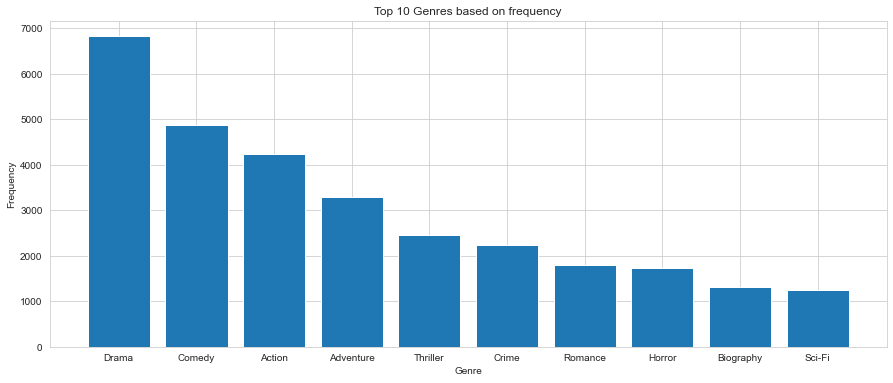

In [94]:
# Genre Frequency Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Count the frequency in each genre
data = final_df['Genres'].value_counts().head(10)
# Get x and y data
x = data.index
y = data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Top 10 Genres based on frequency')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
# Save figure
#plt.savefig('Top Genre Frequency.png')

Text(0, 0.5, 'ROI')

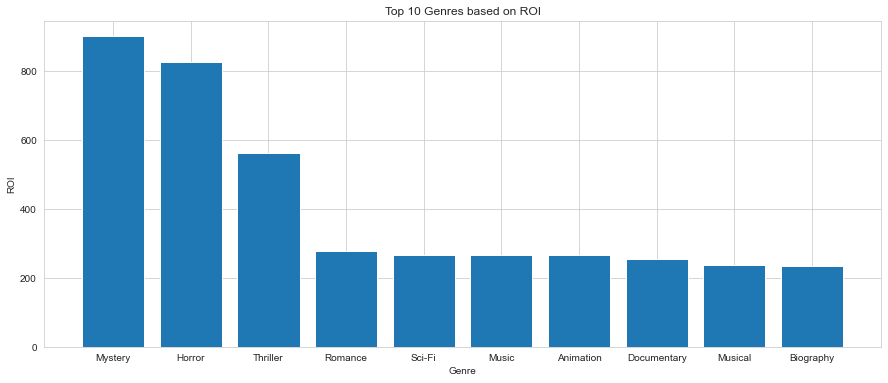

In [95]:
# Genre ROI Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Calculate the mean ROI of each genre and find top 10 genre
ROI_data = final_df.groupby(['Genres']).ROI.mean()
ROI_data = ROI_data.sort_values(ascending= False).head(10)
# Get x and y data
x = ROI_data.index
y = ROI_data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Top 10 Genres based on ROI')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI')
# Save figure
#plt.savefig('Top Genre ROI.png')

Text(0, 0.5, 'Worldwide Profit (M)')

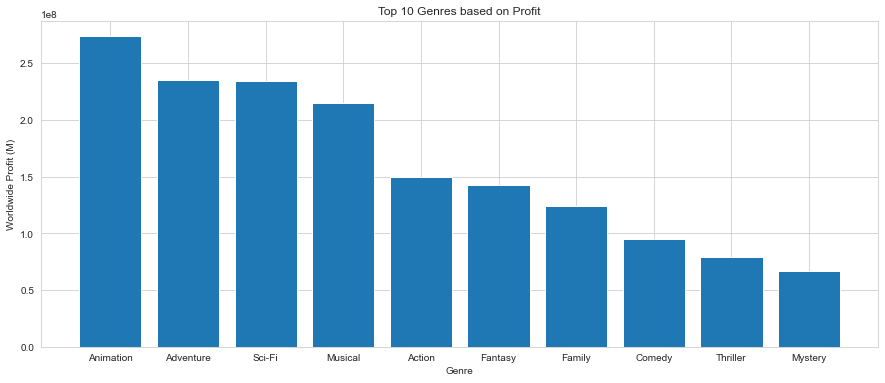

In [96]:
# Genre Profit Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Calculate the mean profit of each genre and find top 10 genre
profit_data = final_df.groupby(['Genres']).Profit.mean()
profit_data = profit_data.sort_values(ascending= False).head(10)
# Get x and y data
x = profit_data.index
y = profit_data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Top 10 Genres based on Profit')
ax.set_xlabel('Genre')
ax.set_ylabel('Worldwide Profit (M)')
# Save figure
#plt.savefig('Top Genre Profit.png')

In [97]:
# Import Seaborn for box plot
import seaborn as sns

In [98]:
# Create a dataframe for genre with top 3 profit
top3 = final_df.loc[(final_df['Genres'] == 'Animation')|(final_df['Genres'] == 'Sci-Fi')|(final_df['Genres'] == 'Adventure')]
top3.head()

,Title,Genres,Released_year,Released_month,Staff_name,Staff_role,Investment,Revenue,Profit,ROI
0,Smurfs: The Lost Village,Adventure,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
1,Smurfs: The Lost Village,Animation,2017,4.0,Mary Ellen Bauder,producer,60000000.0,197578586.0,137578586.0,229.297643
3,Smurfs: The Lost Village,Adventure,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
4,Smurfs: The Lost Village,Animation,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
6,Smurfs: The Lost Village,Adventure,2017,4.0,Jordan Kerner,producer,60000000.0,197578586.0,137578586.0,229.297643


Text(0.5, 1.0, 'Profit Distribution for Top 3 Genre')

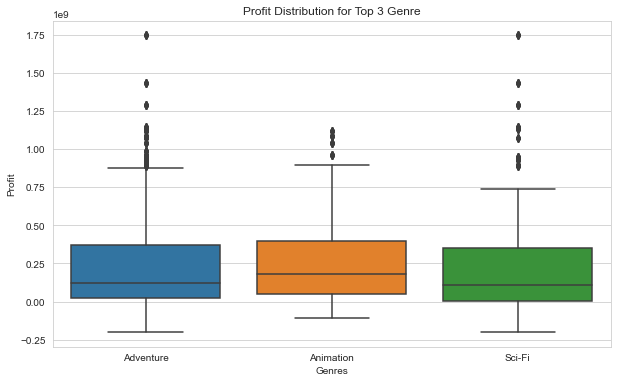

In [99]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x='Genres', y = 'Profit', data= top3)
ax.set_title('Profit Distribution for Top 3 Genre')
#plt.savefig('Box Plot Genre Profit.png')

Text(0.5, 1.0, 'ROI Distribution for Top 3 Genre')

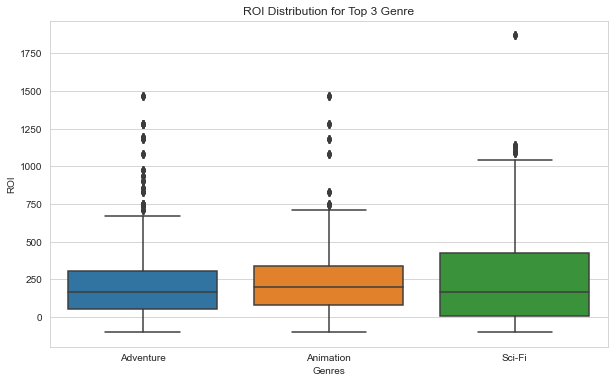

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x='Genres', y = 'ROI', data= top3)
ax.set_title('ROI Distribution for Top 3 Genre')
#plt.savefig('Box Plot Genre ROI.png')

In [101]:
def genre_profit(genre):
    """
    Function which prints out the statistical data for profit and ROI for each genre inf final_df
    if the genre name is entered in string
    """
    sample_df = final_df.loc[final_df['Genres'] == genre]
    print(genre)
    print('<Profit in Millions>')
    print(sample_df['Profit'].describe()/10**6)
    print()
    print('<ROI>')
    print(sample_df['ROI'].describe())
    print()

In [102]:
# Find statistical data for Adventure Movies
genre_profit('Adventure')

Adventure
<Profit in Millions>
count       0.003293
mean      234.907616
std       292.180843
min      -200.237650
25%        22.897191
50%       124.774690
75%       368.214888
max      1748.134200
Name: Profit, dtype: float64

<ROI>
count    3293.000000
mean      208.720830
std       242.739320
min      -100.000000
25%        50.378670
50%       162.794441
75%       302.716661
max      1468.021855
Name: ROI, dtype: float64



In [103]:
# Find statistical data for Animation Movies
genre_profit('Animation')

Animation
<Profit in Millions>
count       0.000987
mean      273.916737
std       283.956724
min      -110.450242
25%        46.594792
50%       178.847930
75%       397.729388
max      1122.469910
Name: Profit, dtype: float64

<ROI>
count     987.000000
mean      265.434592
std       286.120621
min      -100.000000
25%        79.105328
50%       199.456497
75%       336.360654
max      1468.021855
Name: ROI, dtype: float64



In [104]:
# Find statistical data for Sci-Fi Movies
genre_profit('Sci-Fi')

Sci-Fi
<Profit in Millions>
count       0.001238
mean      234.385366
std       326.981891
min      -200.237650
25%         2.982519
50%       110.098259
75%       351.530715
max      1748.134200
Name: Profit, dtype: float64

<ROI>
count    1238.000000
mean      267.500762
std       337.237616
min      -100.000000
25%         3.039258
50%       168.386218
75%       422.202901
max      1867.778200
Name: ROI, dtype: float64



# Month to Release Film

[Text(1, 0, 'January'),
 Text(2, 0, 'February'),
 Text(3, 0, 'March'),
 Text(4, 0, 'April'),
 Text(5, 0, 'May'),
 Text(6, 0, 'June'),
 Text(7, 0, 'July'),
 Text(8, 0, 'August'),
 Text(9, 0, 'September'),
 Text(10, 0, 'October'),
 Text(11, 0, 'November'),
 Text(12, 0, 'December')]

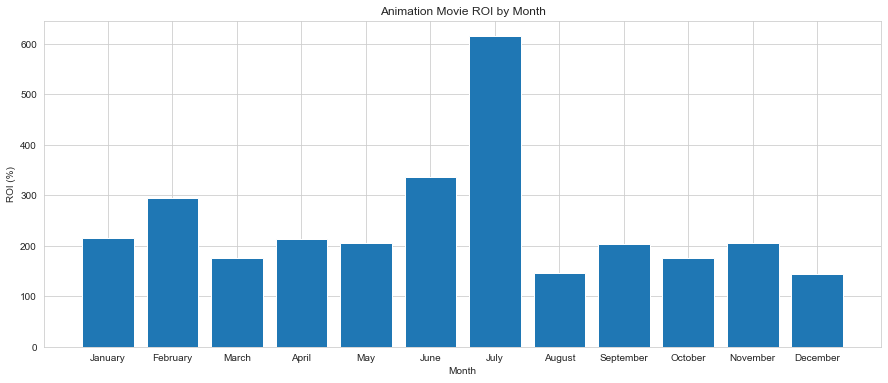

In [105]:
# Suggest the month to release film based on ROI average per month
# Animation Film
g_df=final_df[final_df['Genres']=='Animation']
g_df = g_df.drop_duplicates('Title')
ga_data = g_df.groupby(['Released_month']).ROI.mean()
# Genre ROI Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Get x and y data
x = ga_data.index
y = ga_data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Animation Movie ROI by Month')
ax.set_xlabel('Month')
ax.set_ylabel('ROI (%)')

# Set tick labels as name of the month corresponding the number
months =['January','February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
months_num = range(1,13)

ax.set_xticks(months_num)
ax.set_xticklabels(months)
# Save figure
#plt.savefig('Anime Monthly ROI.png')

[Text(1, 0, 'January'),
 Text(2, 0, 'February'),
 Text(3, 0, 'March'),
 Text(4, 0, 'April'),
 Text(5, 0, 'May'),
 Text(6, 0, 'June'),
 Text(7, 0, 'July'),
 Text(8, 0, 'August'),
 Text(9, 0, 'September'),
 Text(10, 0, 'October'),
 Text(11, 0, 'November'),
 Text(12, 0, 'December')]

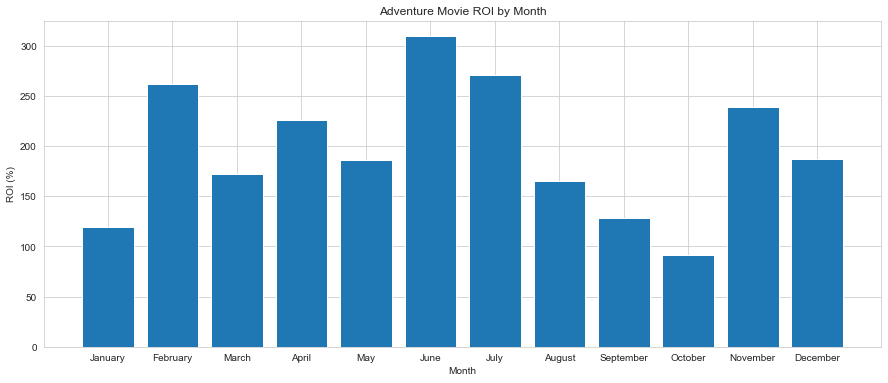

In [106]:
# Suggest the month to release film based on ROI average per month
# Adventure Film
g_df=final_df[final_df['Genres']=='Adventure']
g_df = g_df.drop_duplicates('Title')
ga_data = g_df.groupby(['Released_month']).ROI.mean()
# Genre ROI Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Get x and y data
x = ga_data.index
y = ga_data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Adventure Movie ROI by Month')
ax.set_xlabel('Month')
ax.set_ylabel('ROI (%)')

# Set tick labels as name of the month corresponding the number
months =['January','February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
months_num = range(1,13)

ax.set_xticks(months_num)
ax.set_xticklabels(months)
# Save figure
#plt.savefig('Adventure Monthly ROI.png')

[Text(1, 0, 'January'),
 Text(2, 0, 'February'),
 Text(3, 0, 'March'),
 Text(4, 0, 'April'),
 Text(5, 0, 'May'),
 Text(6, 0, 'June'),
 Text(7, 0, 'July'),
 Text(8, 0, 'August'),
 Text(9, 0, 'September'),
 Text(10, 0, 'October'),
 Text(11, 0, 'November'),
 Text(12, 0, 'December')]

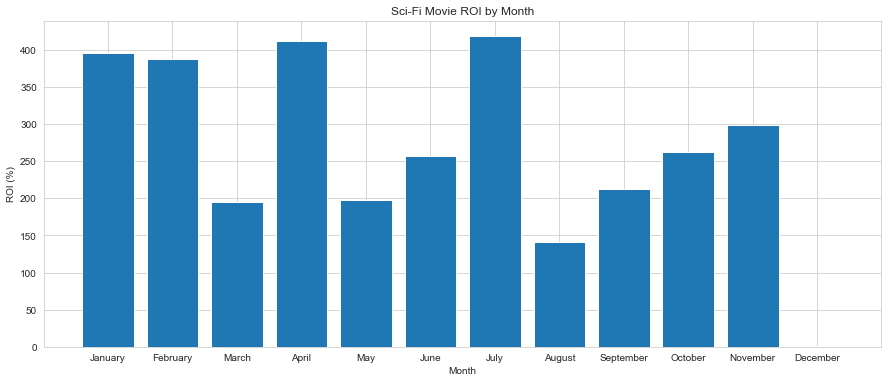

In [107]:
# Suggest the month to release film based on ROI average per month
# Sci-Fi Film
g_df=final_df[final_df['Genres']=='Sci-Fi']
g_df = g_df.drop_duplicates('Title')
ga_data = g_df.groupby(['Released_month']).ROI.mean()
# Genre ROI Analysis
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,6))
# Get x and y data
x = ga_data.index
y = ga_data.values 
# Create bar chart
ax.bar(x, y) 
# Set title and labels
ax.set_title('Sci-Fi Movie ROI by Month')
ax.set_xlabel('Month')
ax.set_ylabel('ROI (%)')

# Set tick labels as name of the month corresponding the number
months =['January','February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
months_num = range(1,13)

ax.set_xticks(months_num)
ax.set_xticklabels(months)
# Save figure
#plt.savefig('Sci-Fi Monthly ROI.png')

In [108]:
directors = final_df[final_df.Staff_role == 'director']


In [109]:
unique_titles_df = directors.drop_duplicates(subset= ['Title'])

In [110]:
profit_directors = unique_titles_df.groupby('Staff_name')['Profit'].sum().sort_values(ascending=False)
top_50_directors = profit_directors.nlargest(50)
top_50_directors_profit = top_50_directors.values.sum()
total_profit = unique_titles_df['Profit'].sum()
top_50_directors_profit_perc = top_50_directors_profit/total_profit
rest_profit = 1 - top_50_directors_profit_perc 

In [111]:
unique_titles_df

,Title,Genres,Released_year,Released_month,Staff_name,Staff_role,Investment,Revenue,Profit,ROI
3,Smurfs: The Lost Village,Adventure,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
45,Hacksaw Ridge,Biography,2016,11.0,Mel Gibson,director,40000000.0,168904682.0,128904682.0,322.261705
78,Robot & Frank,Comedy,2012,8.0,Jake Schreier,director,2500000.0,4934356.0,2434356.0,97.374240
95,Cop Car,Crime,2015,8.0,Jon Watts,director,5000000.0,143658.0,-4856342.0,-97.126840
119,Hearts Beat Loud,Comedy,2018,6.0,Brett Haley,director,2000000.0,2420962.0,420962.0,21.048100
...,...,...,...,...,...,...,...,...,...,...
35863,The Ridges,Drama,2011,11.0,Brandon Landers,director,17300.0,0.0,-17300.0,-100.000000
35869,The Great Wall,Documentary,2017,2.0,Tadhg O'Sullivan,director,150000000.0,334486852.0,184486852.0,122.991235
35875,Fight Valley,Action,2016,7.0,Rob Hawk,director,20000000.0,0.0,-20000000.0,-100.000000
35891,Stories of Our Lives,Drama,2014,12.0,Jim Chuchu,director,15000.0,0.0,-15000.0,-100.000000


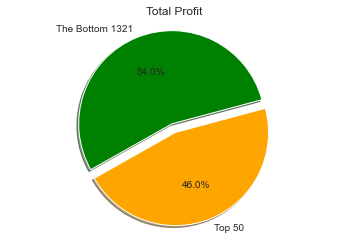

<Figure size 432x288 with 0 Axes>

In [117]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
my_data = [rest_profit, top_50_directors_profit_perc]
my_labels = 'The Bottom 1321', 'Top 50'
my_colors = ['green','orange']
my_explode = (0, 0.1)
plt.pie(my_data,labels = my_labels,autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('Total Profit')
plt.axis('equal')
plt.show()
plt.savefig('Directors_Pie_chart.png')

,Title,Genres,Released_year,Released_month,Staff_name,Staff_role,Investment,Revenue,Profit,ROI
3,Smurfs: The Lost Village,Adventure,2017,4.0,Kelly Asbury,director,60000000.0,197578586.0,137578586.0,229.297643
45,Hacksaw Ridge,Biography,2016,11.0,Mel Gibson,director,40000000.0,168904682.0,128904682.0,322.261705
78,Robot & Frank,Comedy,2012,8.0,Jake Schreier,director,2500000.0,4934356.0,2434356.0,97.374240
95,Cop Car,Crime,2015,8.0,Jon Watts,director,5000000.0,143658.0,-4856342.0,-97.126840
119,Hearts Beat Loud,Comedy,2018,6.0,Brett Haley,director,2000000.0,2420962.0,420962.0,21.048100
...,...,...,...,...,...,...,...,...,...,...
35863,The Ridges,Drama,2011,11.0,Brandon Landers,director,17300.0,0.0,-17300.0,-100.000000
35869,The Great Wall,Documentary,2017,2.0,Tadhg O'Sullivan,director,150000000.0,334486852.0,184486852.0,122.991235
35875,Fight Valley,Action,2016,7.0,Rob Hawk,director,20000000.0,0.0,-20000000.0,-100.000000
35891,Stories of Our Lives,Drama,2014,12.0,Jim Chuchu,director,15000.0,0.0,-15000.0,-100.000000
